# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import warnings

from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
print(os.listdir('/datasets/faces/'))
print(len(os.listdir('/datasets/faces/final_files')))

['labels.csv', 'final_files']
7591


In [3]:
pth = '/datasets/faces/labels.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth, sep = ',')    
else:
    print('Ошибка в считывании данных из источника {}'.format(pth))

In [4]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Выведем вручную одну картинку из папки.

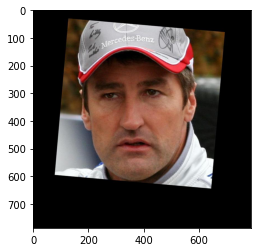

In [5]:
image = Image.open('/datasets/faces/final_files/005226.jpg')
plt.imshow(np.array(image))
plt.show()

**Загрузим все фотографии из папки в трейновую и валидационную выборки в отношении 3:1 используя ImageDataGenerator.**

In [6]:
train_datagen = ImageDataGenerator(validation_split=0.25, 
                                   rescale=1/255.,
                                  # horizontal_flip=True,
                                 # vertical_flip=True,
                                 # rotation_range=90,
                                 # width_shift_range=0.2,
                                 # height_shift_range=0.2
                                  )

validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

train_datagen_flow = train_datagen.flow_from_dataframe(data, 
                    directory='/datasets/faces/final_files/',
                    batch_size=32,                       
                    x_col='file_name', 
                    y_col='real_age',
                    class_mode = 'raw',
                    shuffle = True,
                    subset='training',
                    seed=12345)

val_datagen_flow = validation_datagen.flow_from_dataframe(data, 
                    directory='/datasets/faces/final_files/',
                    batch_size=32,                       
                    x_col='file_name', 
                    y_col='real_age',
                    class_mode = 'raw',
                    shuffle = True,
                    subset='validation',                                                      
                    seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [7]:
print(type(train_datagen_flow[0][0]))
(train_datagen_flow[0][0]).shape

<class 'numpy.ndarray'>


(32, 256, 256, 3)

In [8]:
type(next(train_datagen_flow)[1][31])

numpy.int64

In [9]:
type(train_datagen_flow[0])

tuple

**Вызовем вручную 1 признак и 1 таргет.** 

Возраст объекта на фото  29



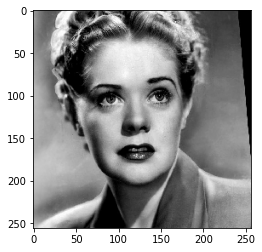

In [10]:
batch = next(train_datagen_flow)
print('Возраст объекта на фото ', batch[1][31])
plt.imshow(batch[0][31])
print()

In [11]:
features, target = next(train_datagen_flow)

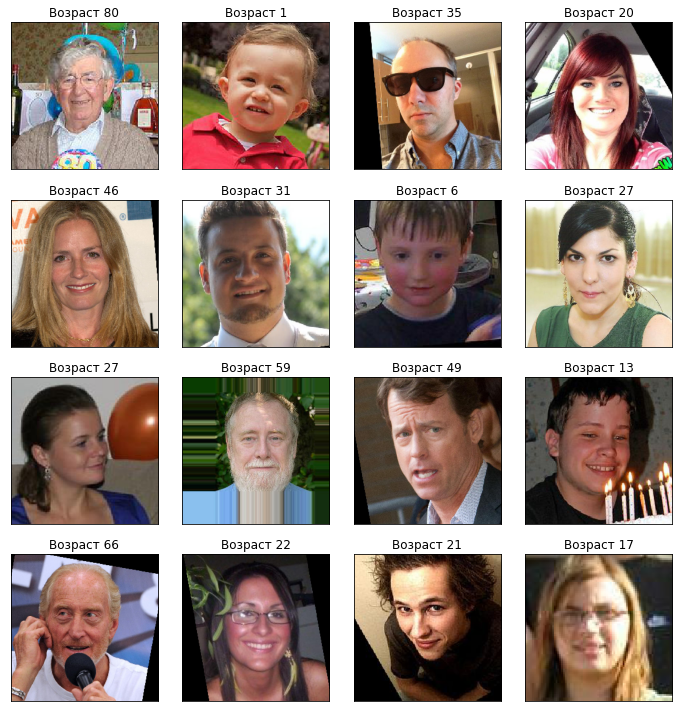

In [12]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.title('Возраст '+ str(target[i]))
    plt.imshow(features[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Посмотрим на распределение целевой переменной.**

In [13]:
data['real_age'].describe().T

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

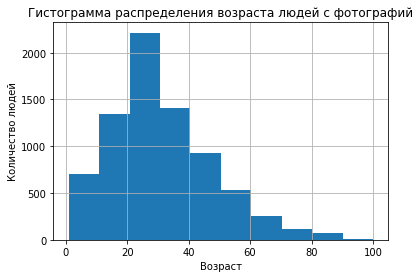

In [14]:
data['real_age'].hist()
plt.title('Гистограмма распределения возраста людей с фотографий')
plt.ylabel('Количество людей')
plt.xlabel('Возраст')
plt.show()

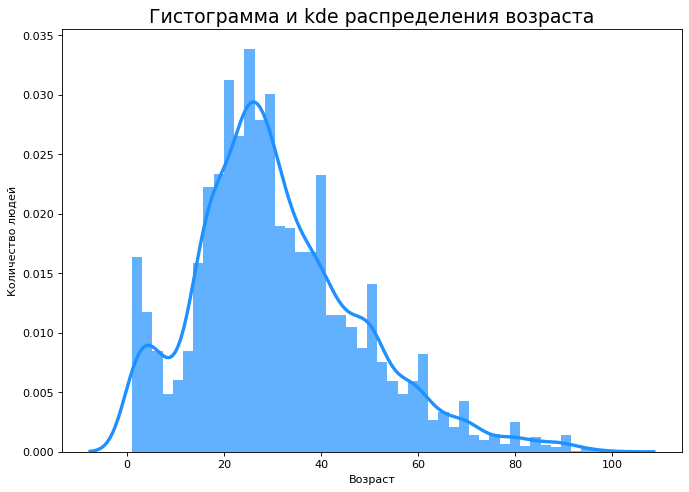

In [15]:
warnings.simplefilter("ignore")
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(data['real_age'], color="dodgerblue", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
plt.title('Гистограмма и kde распределения возраста', fontsize=17)
plt.ylabel('Количество людей')
plt.xlabel('Возраст')
plt.show()

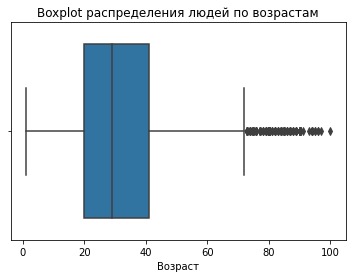

In [16]:
sns.boxplot(data['real_age'])
plt.title('Boxplot распределения людей по возрастам')
plt.xlabel('Возраст')
plt.show()

In [17]:
length = []
width = []
list = os.listdir('/datasets/faces/final_files')
for i in range(len(list)):
    image = Image.open('/datasets/faces/final_files/'+list[i])
    l = np.array(image).shape[0]
    w = np.array(image).shape[1]
    length.append(l)
    width.append(w)

In [18]:
length = pd.Series(length)
width = pd.Series(width)
len(width)

7591

In [19]:
counter = 0
for i in range(len(width)):
    if width[i] - length[i] < 2:
        counter += 1
print('Количество квадратных фотографий: ', counter)
print('Количество неквадратных фотографий: ', len(width) - counter)

Количество квадратных фотографий:  7474
Количество неквадратных фотографий:  117


In [20]:
length.describe()

count    7591.000000
mean      464.093927
std       331.289883
min        47.000000
25%       220.000000
50%       384.000000
75%       632.000000
max      4466.000000
dtype: float64

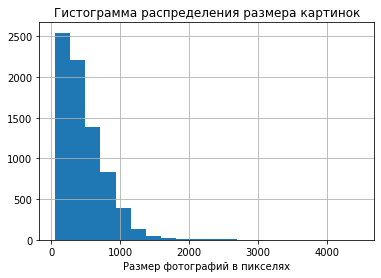

In [21]:
length.hist(bins = 20)
plt.title('Гистограмма распределения размера картинок')
plt.xlabel('Размер фотографий в пикселях')
plt.show()

Фотографии имеют различный размер, далее в обучении модели все картинки будут ресайзится до размера 224*224. Для большинства картинок (порядка 70%) это будет изменение в сторону сжатия. 

**Вывод: распределение возраста близко к нормальному, имеет правую асимметрию и локальный максимум для детей. Также имеется довольно мало фотографий людей старше 80 лет. Но при этом для нашей задачи (модель для магазина) это не является проблемой, т.к. посетители старше 80 лет редко ходят по магазинам.** 

**В датасете содержатся в основном цветные изображения. На некоторых изображениях имеются искажения, затрудняющие распознавание.
В датасете порядка 1,5% неквадратных фотографий. Также имеются фотографии с черными углами/участками/полосами. 
На имеющихся у нас фотографиях уже была призведена детекция лица. На всех изображениях лица людей, расположенные в основном в центре.**

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import os

def load_train(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.,
                                        horizontal_flip=True,
                                        width_shift_range=0.1)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

## Результат обучения и теста модели:

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 106s - loss: 248.1270 - mae: 11.2207 - val_loss: 793.7679 - val_mae: 23.2572
Epoch 2/10
178/178 - 93s - loss: 83.8928 - mae: 6.8710 - val_loss: 580.7182 - val_mae: 19.0601
Epoch 3/10
178/178 - 95s - loss: 59.1757 - mae: 5.8645 - val_loss: 234.7607 - val_mae: 11.4951
Epoch 4/10
178/178 - 92s - loss: 43.4161 - mae: 5.0155 - val_loss: 121.4312 - val_mae: 8.5430
Epoch 5/10
178/178 - 96s - loss: 34.3675 - mae: 4.4856 - val_loss: 102.1188 - val_mae: 7.6842
Epoch 6/10
178/178 - 103s - loss: 29.3555 - mae: 4.1491 - val_loss: 149.6446 - val_mae: 9.6547
Epoch 7/10
178/178 - 103s - loss: 23.8625 - mae: 3.7783 - val_loss: 77.2030 - val_mae: 6.6617
Epoch 8/10
178/178 - 101s - loss: 20.0474 - mae: 3.4511 - val_loss: 76.0505 - val_mae: 6.3331
Epoch 9/10
178/178 - 103s - loss: 17.9067 - mae: 3.2234 - val_loss: 70.2274 - val_mae: 6.4228
Epoch 10/10
178/178 - 99s - loss: 15.4548 - mae: 2.9973 - val_loss: 67.8516 - val_mae: 6.1955
60/60 - 11s - loss: 67.8516 - mae: 6.1955

Test MAE: 6.1955
```

## Анализ обученной модели

В данной работе по распознаванию возраста человека по фотографии лица мы использовали предобученную нейросетевую модель ResNet50, решали задачу регрессии. На тесте модель достигла значения MAE = 6.2 за 10 эпох. Размер тестовой выборки составлял 25% от всего набора данных. 

БОльшая ошибка на трейне свидетельствует о переобучении модели, на трейне MAE составлят 3 года против 6 лет в тесте. 
Скорее всего показатели можно улучшить добавив аугментацию, уменьшив шаг, увеличив при это количество эпох. 
Также меньшей ошибки можно добиться проведя более тщательный анализ датасета, выбросить бракованные фотографии, прямоугольные фотографии и т.д. В нашей работе мы такой шаг не проводили. 